# AT&T Spam Detector

# DATA Exploration & Preparation

## Install & import data

In [353]:
# Load in our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import plot

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"])
pio.templates.default = "jedha"
#pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, GlobalAveragePooling1D, Dropout, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.optimizers import Adam

In [354]:
dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1")
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## EDA

In [355]:
# Basic stats
print("Set with labels (our train+test) : {}".format(dataset.shape))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])


Set with labels (our train+test) : (5572, 5)

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [356]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [357]:
dataset['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [358]:
target_pct = dataset['v1'].value_counts() / dataset['v1'].value_counts().sum() * 100
target_pct

ham     86.593683
spam    13.406317
Name: v1, dtype: float64

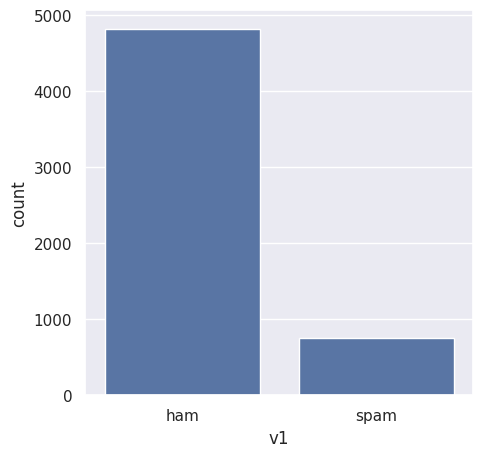

In [359]:
# Distribution of ham and spam messages
plt.figure(figsize=(5,5))
sns.countplot(x ='v1', data = dataset)
plt.show()

In [360]:
data2 = dataset[dataset['Unnamed: 4'].isnull() == False]
print(len(data2))
display(data2)

6


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
2255,ham,I just lov this line: \Hurt me with the truth,I don't mind,i wil tolerat.bcs ur my someone..... But,"Never comfort me with a lie\"" gud ni8 and swe..."
3525,ham,\HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...,HAD A COOL NYTHO,TX 4 FONIN HON,"CALL 2MWEN IM BK FRMCLOUD 9! J X\"""""
4668,ham,"When I was born, GOD said, \Oh No! Another IDI...",GOD said,"\""OH No! COMPETITION\"". Who knew","one day these two will become FREINDS FOREVER!"""
5048,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""


In [361]:
dataset = dataset.rename(columns={'v1' : 'target', 'v2' : 'mail'})

In [362]:
dataset['number_character']=dataset['mail'].apply(len)
dataset.head()

,target,mail,Unnamed: 2,Unnamed: 3,Unnamed: 4,number_character
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,61


<Figure size 500x500 with 0 Axes>

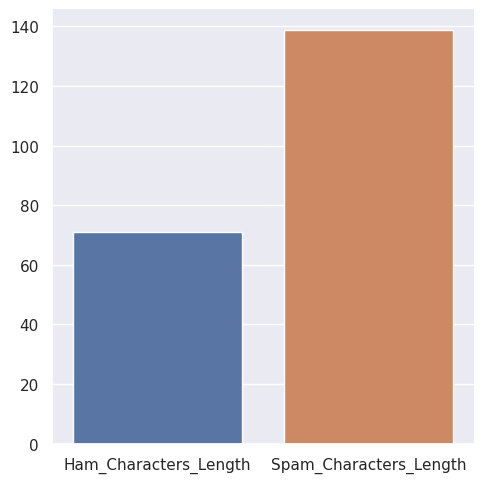

In [363]:
# Average character's lenght for spam and ham messages
ham_data_len_ch = dataset[dataset["target"]=="ham"]["number_character"].mean()
spam_data_len_ch = dataset[dataset["target"]=="spam"]["number_character"].mean()
ch_len_dict = {'Ham_Characters_Length' : ham_data_len_ch, 'Spam_Characters_Length' : spam_data_len_ch}
ch_len_df = pd.DataFrame.from_dict(ch_len_dict, orient='index').T
plt.figure(figsize=(5,5))
sns.catplot(ch_len_df, kind="bar")
plt.show()

In [364]:
dataset['number_of_words'] = dataset['mail'].apply(lambda x: len(x.split()))
dataset.head()

,target,mail,Unnamed: 2,Unnamed: 3,Unnamed: 4,number_character,number_of_words
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111,20
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155,28
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,61,13


<Figure size 500x500 with 0 Axes>

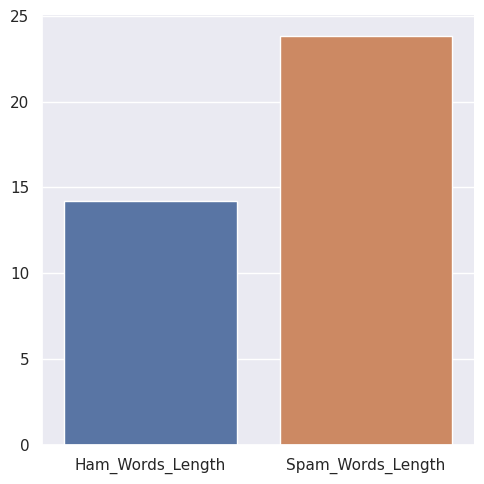

In [365]:
# Average number of words for spam and ham messages
ham_data_len_wd = dataset[dataset["target"]=="ham"]["number_of_words"].mean()
spam_data_len_wd = dataset[dataset["target"]=="spam"]["number_of_words"].mean()
wd_len_dict = {'Ham_Words_Length' : ham_data_len_wd, 'Spam_Words_Length' : spam_data_len_wd}
wd_len_df = pd.DataFrame.from_dict(wd_len_dict, orient='index').T
plt.figure(figsize=(5,5))
sns.catplot(wd_len_df, kind="bar")
plt.show()

### WordCloud & Current Words

All data

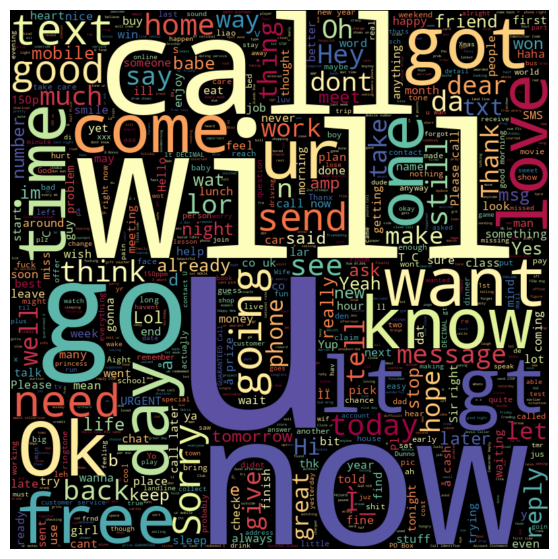

In [366]:
# All data

plt.figure(figsize=(7,7))

all_text=" ".join(dataset['mail'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="Spectral").generate(all_text)
# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Ham Data

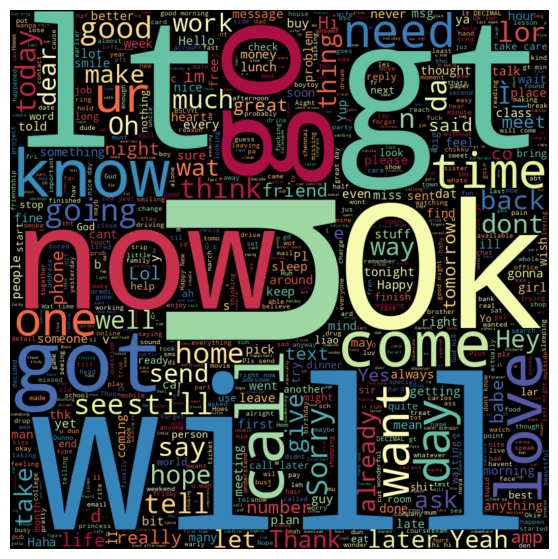

In [367]:
# Ham data

plt.figure(figsize=(7,7))
ham_data_wordcloud=dataset[dataset["target"]=='ham']
ham_text=" ".join(ham_data_wordcloud['mail'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="Spectral").generate(ham_text)
# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Spam Data

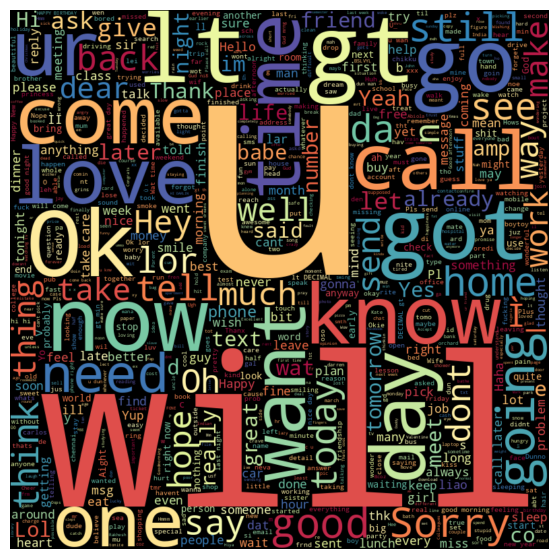

In [368]:
# Spam Data

plt.figure(figsize=(7,7))
spam_data_wordcloud=dataset[dataset["target"]=='spam']
spam_text=" ".join(ham_data_wordcloud['mail'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="Spectral").generate(ham_text)
# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Preprocessing

In [369]:
# Let's take the columns we're interested in
data = dataset[["target", "mail"]]
# Encodind label
data['label'] = data['target'].apply(lambda x: 0 if x == 'ham' else 1)
data.head()

<ipython-input-369-1696fc0a9864>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,target,mail,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [370]:
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [371]:
# Import Spacy and english initialisation
import en_core_web_sm
nlp = en_core_web_sm.load()
# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [372]:
# Data Cleaning
data["mail_clean"] = data["mail"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
data["mail_clean"] = data["mail_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
data["mail_clean"] = data["mail_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

data.head()

<ipython-input-372-2f8b3e38b721>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-372-2f8b3e38b721>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-372-2f8b3e38b721>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,target,mail,label,mail_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live


In [373]:
mask = data["mail_clean"].isna()==False
data = data[mask]
data.head()

,target,mail,label,mail_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live


In [374]:
# Tokenize mails
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="<out_of_vocab>") # instanciate the tokenizer
"""
num_words=1000, oov_token="<out_of_vocab>")
"""
tokenizer.fit_on_texts(data["mail_clean"])
data["mail_encoded"] = tokenizer.texts_to_sequences(data['mail_clean'])
data["len_mail"] = data["mail_encoded"].apply(lambda x: len(x))
data = data[data["len_mail"]!=0]

In [375]:
data.head()

,target,mail,label,mail_clean,mail_encoded,len_mail
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...,"[1, 230, 446, 463, 941, 32, 50, 204, 942, 78, ...",14
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,"[8, 195, 464, 289, 2, 1]",6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 300, 3, 532, 661, 30, 1, 848, 423, 1, 1, ...",22
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c,"[2, 125, 150, 1, 2, 79]",6
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live,"[704, 20, 662, 129]",4


### Word Frequencies

In [376]:
# Top 10 Words in tokenizer
print({key: value for key, value in tokenizer.index_word.items() if key <= 10})

{1: '<out_of_vocab>', 2: 'u', 3: '2', 4: 'ur', 5: 'come', 6: '4', 7: 'know', 8: 'ok', 9: 'ltgt', 10: 'good'}


In [377]:
# pour voir si tokenizer num_words utile ? ou trop faible ? 1 000 , 10 000 ?
len(tokenizer.index_word)

8188

<ipython-input-378-7fbf9cae0cd6>:19: UserWarning:

FixedFormatter should only be used together with FixedLocator



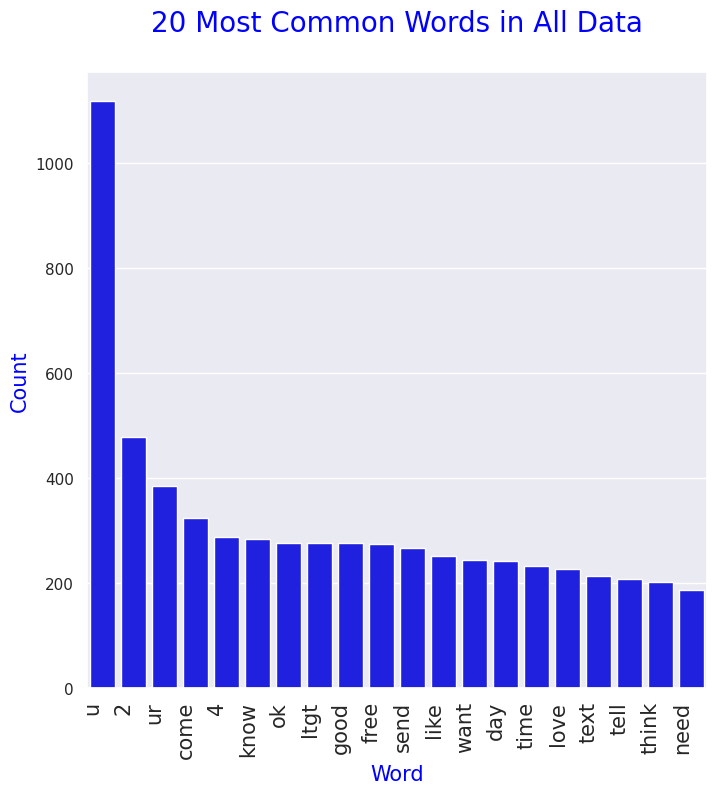

In [378]:
# All Data

most_common_word = data['mail_clean']
# extract text data from 'text' column
most_common_text = " ".join(most_common_word.values.tolist())
# split the text into words
word_freq = most_common_text.split()
# count the frequency of each word
count_words = Counter(word_freq)
# sort the words by frequency in descending order
most_common_words = count_words.most_common(20)
# create a new DataFrame with the word counts
data_frame = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

# plot the word counts using a barplot
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.barplot(x="Word", y="Count", data=data_frame, color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=15)
plt.title("20 Most Common Words in All Data\n", fontsize=20, color="blue")
plt.xlabel("Word", fontsize=15, color="blue")
plt.ylabel("Count", fontsize=15, color="blue")
plt.show()

<ipython-input-379-f321ebaae7ad>:21: UserWarning:

FixedFormatter should only be used together with FixedLocator



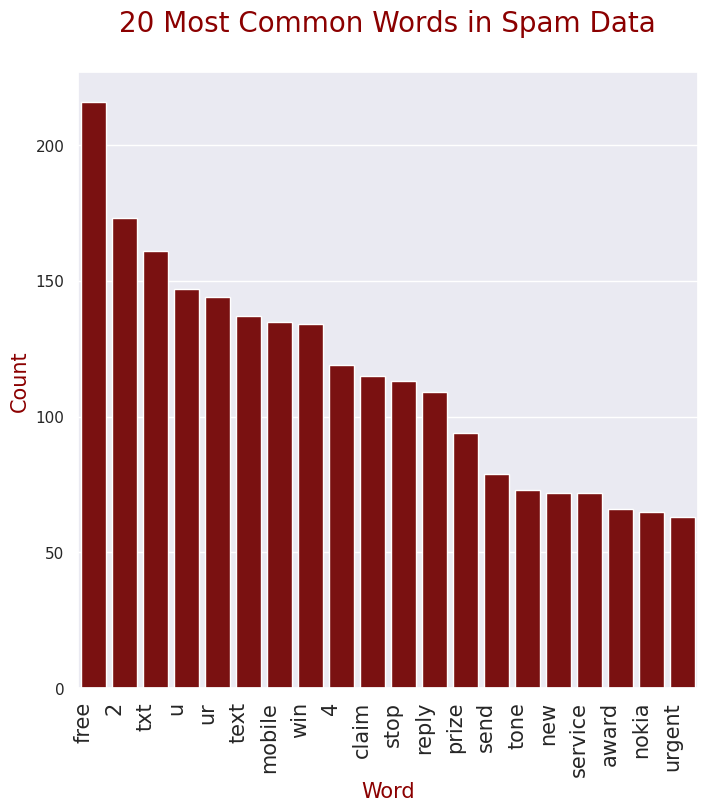

In [379]:
# Spam Data

# selecting spam
most_common_spam_word = data[data["label"]==1]
most_common_spam_word = most_common_spam_word['mail_clean']
# extract text data from 'text' column
most_common_spam_text = " ".join(most_common_spam_word.values.tolist())
# split the text into words
spam_word_freq = most_common_spam_text.split()
# count the frequency of each word
count_spam_words = Counter(spam_word_freq)
# sort the words by frequency in descending order
most_common_words_spam = count_spam_words.most_common(20)
# create a new DataFrame with the word counts
spam_data_frame = pd.DataFrame(most_common_words_spam, columns=['Word', 'Count'])

# plot the word counts using a barplot
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.barplot(x="Word", y="Count", data=spam_data_frame, color="darkred")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=15)
plt.title("20 Most Common Words in Spam Data\n", fontsize=20, color="darkred")
plt.xlabel("Word", fontsize=15, color="darkred")
plt.ylabel("Count", fontsize=15, color="darkred")
plt.show()

<ipython-input-380-a2938c47ce0a>:21: UserWarning:

FixedFormatter should only be used together with FixedLocator



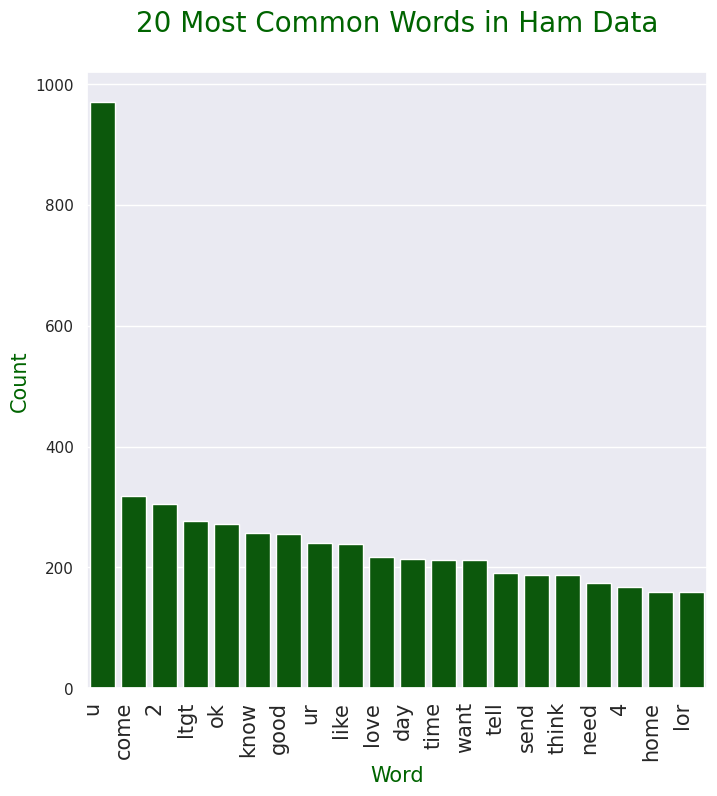

In [380]:
# Ham Data

# selecting ham
most_common_ham_word = data[data["label"]==0]
most_common_ham_word = most_common_ham_word['mail_clean']
# extract text data from 'text' column
most_common_ham_text = " ".join(most_common_ham_word.values.tolist())
# split the text into words
ham_word_freq = most_common_ham_text.split()
# count the frequency of each word
count_ham_words = Counter(ham_word_freq)
# sort the words by frequency in descending order
most_common_words_ham = count_ham_words.most_common(20)
# create a new DataFrame with the word counts
ham_data_frame = pd.DataFrame(most_common_words_ham, columns=['Word', 'Count'])

# plot the word counts using a barplot
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.barplot(x="Word", y="Count", data=ham_data_frame, color="darkgreen")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=15)
plt.title("20 Most Common Words in Ham Data\n", fontsize=20, color="darkgreen")
plt.xlabel("Word", fontsize=15, color="darkgreen")
plt.ylabel("Count", fontsize=15, color="darkgreen")
plt.show()

### Padding, Train Test Split, Tensor & Batch

In [381]:
mail_pad = tf.keras.preprocessing.sequence.pad_sequences(data['mail_encoded'], padding="post")

In [382]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(mail_pad, data['label'], test_size=0.3, stratify=data['label'])

In [383]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [384]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [385]:
 # Regardons un batch
for mail, label in train_batch.take(1):
  print(mail, label)

tf.Tensor(
[[580   1   1 ...   0   0   0]
 [  1  34  31 ...   0   0   0]
 [467   1   7 ...   0   0   0]
 ...
 [  8 681   7 ...   0   0   0]
 [ 14   1 603 ...   0   0   0]
 [  1 405   1 ...   0   0   0]], shape=(64, 74), dtype=int32) tf.Tensor(
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0], shape=(64,), dtype=int64)


In [386]:
vocab_size = tokenizer.num_words
vocab_size

1000

In [387]:
mail.shape

TensorShape([64, 74])

In [388]:
label.shape

TensorShape([64])

# Build & Train Models

In [389]:
# Calcul des poids des 2 classes (ham & spam) pour contrer le déséquilibre des classes dans le dataset

weights = 1/(data["label"].value_counts())
weights = weights * len(data)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.5776991886831704, 1: 3.717536813922356}

## Modeling Dense

In [390]:
model_dense = tf.keras.Sequential([
                  # Couche d'Input Word Embedding
                  Embedding(vocab_size+1, 64, input_shape=[mail.shape[1],],name="embedding"),

                  # Gobal average pooling
                  GlobalAveragePooling1D(),

                  # Couche Dense classique
                  Dense(32, activation='relu'),

                  # Couche Dropout pour éviter l'overfitting
                  Dropout(0.4),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  Dense(1, activation="sigmoid")
])

In [391]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)
model_dense.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [392]:
model_dense.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 64)            64064     
                                                                 
 global_average_pooling1d_4  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_44 (Dense)            (None, 32)                2080      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_45 (Dense)            (None, 1)                 33        
                                                                 
Total params: 66177 (258.50 KB)
Trainable params: 66177 (258.50 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [393]:
history_de = model_dense.fit(train_batch,
                    epochs=30,
                    validation_data=val_batch,
                    class_weight=weights)

Epoch 1/30
61/61 [==============================] - 2s 13ms/step - loss: 0.6872 - binary_accuracy: 0.8060 - val_loss: 0.6573 - val_binary_accuracy: 0.8914
Epoch 2/30
61/61 [==============================] - 1s 11ms/step - loss: 0.6552 - binary_accuracy: 0.8935 - val_loss: 0.5805 - val_binary_accuracy: 0.9382
Epoch 3/30
61/61 [==============================] - 1s 9ms/step - loss: 0.5552 - binary_accuracy: 0.9138 - val_loss: 0.4740 - val_binary_accuracy: 0.9238
Epoch 4/30
61/61 [==============================] - 1s 10ms/step - loss: 0.4128 - binary_accuracy: 0.9282 - val_loss: 0.3228 - val_binary_accuracy: 0.9340
Epoch 5/30
61/61 [==============================] - 1s 15ms/step - loss: 0.3021 - binary_accuracy: 0.9321 - val_loss: 0.2563 - val_binary_accuracy: 0.9382
Epoch 6/30
61/61 [==============================] - 1s 10ms/step - loss: 0.2443 - binary_accuracy: 0.9421 - val_loss: 0.2115 - val_binary_accuracy: 0.9436
Epoch 7/30
61/61 [==============================] - 1s 11ms/step - loss

#### Evaluation

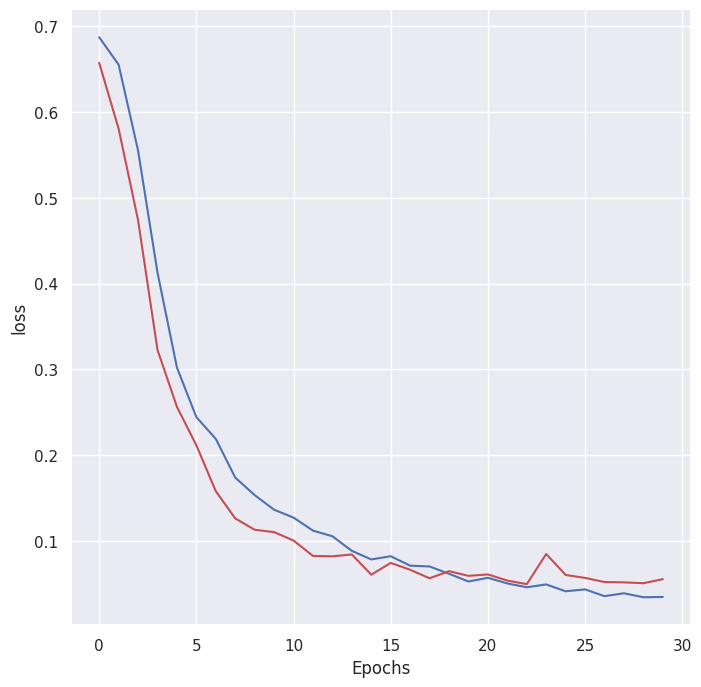

In [394]:
# Visualization of the training process on the loss function
plt.plot(history_de.history["loss"], color="b")
plt.plot(history_de.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [395]:
history_de.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

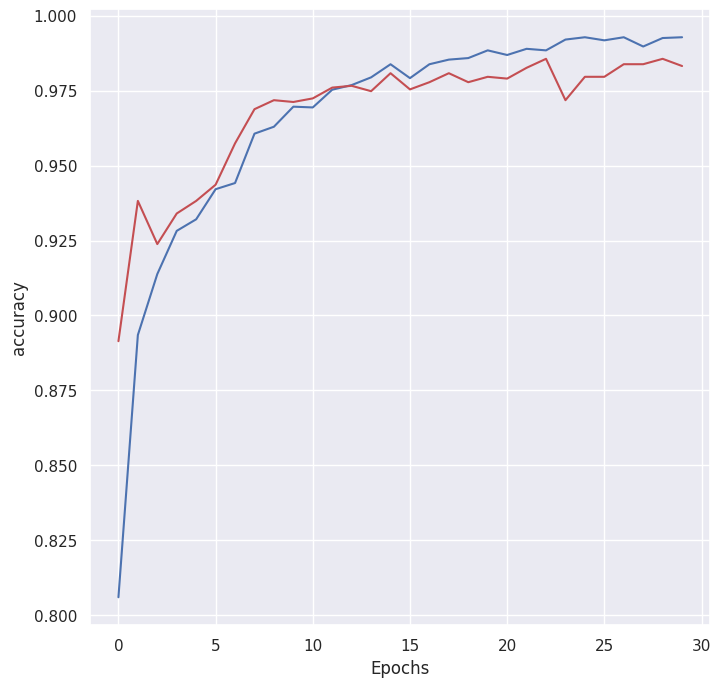

In [396]:
# Visualization of accuracy training
plt.plot(history_de.history["binary_accuracy"], color="b")
plt.plot(history_de.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

53/53 [==============================] - 0s 4ms/step


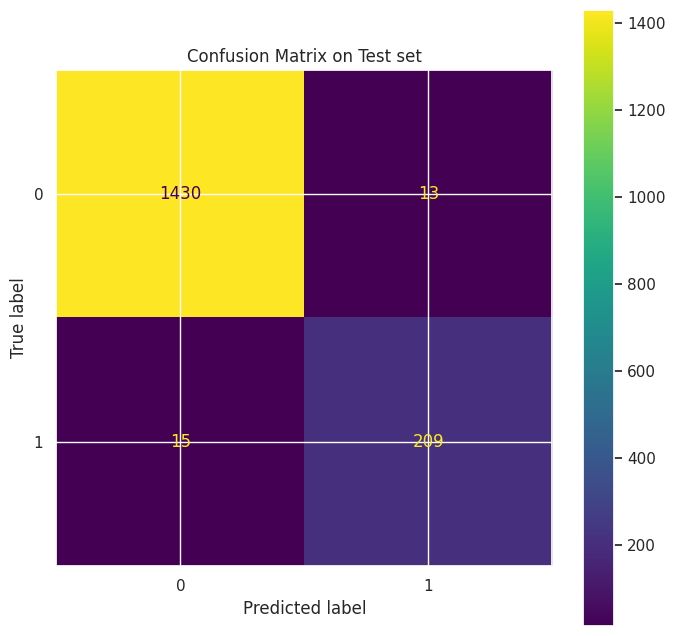

In [397]:
val_prediction = np.round(model_dense.predict(X_val))
# Confusion Matrix
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_predictions(y_val, val_prediction, ax=ax)
plt.show()

In [398]:
train_dense_results = model_dense.evaluate(X_train, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model_dense.evaluate(X_val, np.asarray(y_val), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

16/16 - 0s - loss: 0.0220 - binary_accuracy: 0.9941 - 113ms/epoch - 7ms/step
7/7 - 0s - loss: 0.0554 - binary_accuracy: 0.9832 - 73ms/epoch - 10ms/step
Train accuracy: 99.41
Valid accuracy: 98.32


In [518]:
model_dense.save("models/model_dense.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



This simple dense model have a high binary accuracy with 99.4% on the training set and 98.3% on the validation set. The binary accuracy of validation test is still improving after 30 epochs, the validation loss still decrease, even if it begins to stagnate towards the end, so we can suppose the model is still learning. The loss of train and validation sets don't shows signs of overfitting. \
With the confusion matrix, we can see that this dense model failed only 13 times to identify a spam (out of 224) and fail 15 times by identifying a ham as spam (out of 1443 instances). It is really good results.

## Modeling Simple RNN

In [449]:
model_srnn = tf.keras.Sequential([
                  # Word Embedding layer
                  Embedding(vocab_size+1, 64, input_shape=[mail.shape[1],],name="embedding"),

                  # Simple RNN layer to add recurence
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=32, return_sequences=False), # returns the last output

                  # Couche Dropout pour éviter l'overfitting
                  Dropout(0.2),

                  # Dense layers once the data is flat
                  #Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # Couche Dropout pour éviter l'overfitting
                  Dropout(0.1),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  Dense(1, activation="sigmoid")
])

In [450]:
optimizer= tf.keras.optimizers.Adam()
model_srnn.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [451]:
model_srnn.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 64)            64064     
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 74, 64)            8256      
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_60 (Dense)            (None, 8)                 264       
                                                                 
 dropout_24 (Dropout)        (None, 8)                 0         
                                                                 
 dense_61 (Dense)            (None, 1)               

In [452]:
# Model training
srnn_history = model_srnn.fit(train_batch,
          epochs=30,
          validation_data=val_batch,
          class_weight=weights)

Epoch 1/30
61/61 [==============================] - 44s 62ms/step - loss: 0.4555 - binary_accuracy: 0.7980 - val_loss: 0.3030 - val_binary_accuracy: 0.9250
Epoch 2/30
61/61 [==============================] - 4s 63ms/step - loss: 0.2582 - binary_accuracy: 0.9462 - val_loss: 0.2188 - val_binary_accuracy: 0.9322
Epoch 3/30
61/61 [==============================] - 4s 60ms/step - loss: 0.2024 - binary_accuracy: 0.9429 - val_loss: 0.1270 - val_binary_accuracy: 0.9646
Epoch 4/30
61/61 [==============================] - 4s 65ms/step - loss: 0.1398 - binary_accuracy: 0.9745 - val_loss: 0.1729 - val_binary_accuracy: 0.9544
Epoch 5/30
61/61 [==============================] - 5s 85ms/step - loss: 0.1198 - binary_accuracy: 0.9820 - val_loss: 0.1473 - val_binary_accuracy: 0.9640
Epoch 6/30
61/61 [==============================] - 4s 68ms/step - loss: 0.1072 - binary_accuracy: 0.9848 - val_loss: 0.2320 - val_binary_accuracy: 0.9454
Epoch 7/30
61/61 [==============================] - 7s 109ms/step - l

#### Evaluation

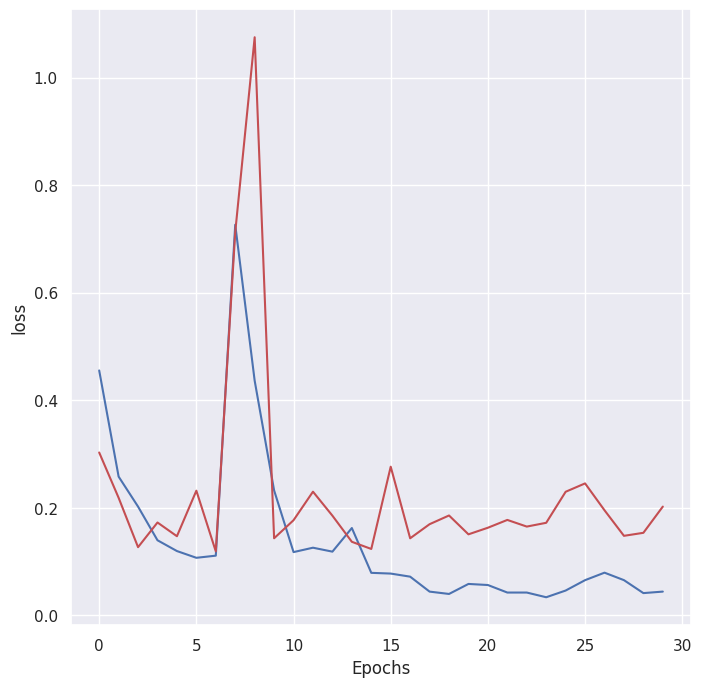

In [453]:
# Visualization of the training process on the loss function
plt.plot(srnn_history.history["loss"], color="b")
plt.plot(srnn_history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

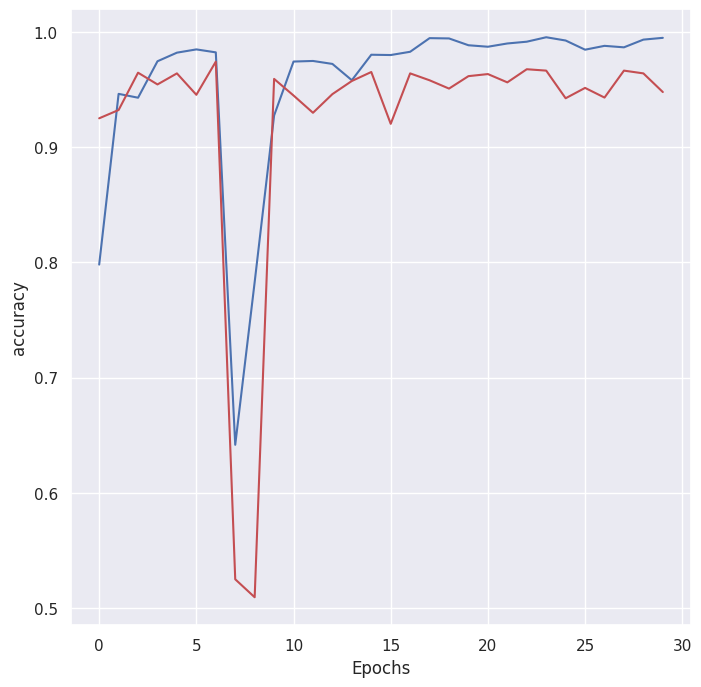

In [454]:
# Visualization of accuracy training
plt.plot(srnn_history.history["binary_accuracy"], color="b")
plt.plot(srnn_history.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

53/53 [==============================] - 1s 12ms/step


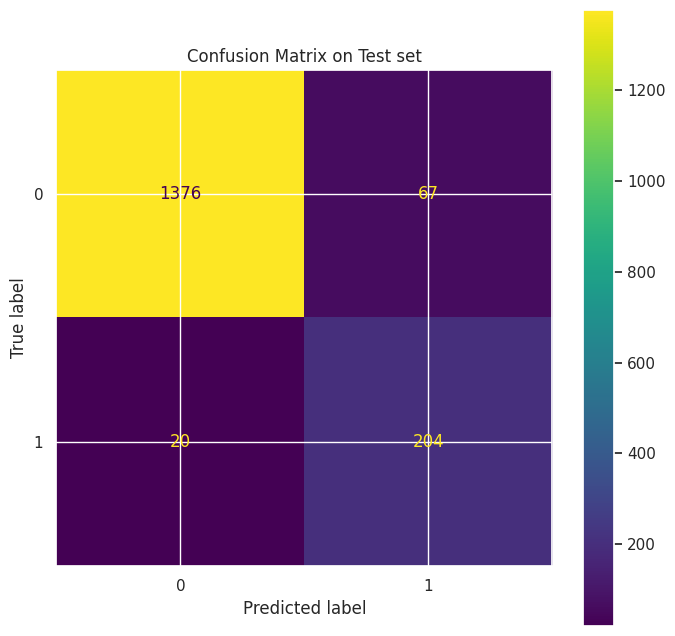

In [455]:
val_prediction = np.round(model_srnn.predict(X_val))
# Confusion Matrix
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_predictions(y_val, val_prediction, ax=ax)
plt.show()

In [456]:
train_srnn_results = model_srnn.evaluate(X_train, np.asarray(y_train), verbose=2, batch_size=256)
valid_srnn_results = model_srnn.evaluate(X_val, np.asarray(y_val), verbose=2, batch_size=256)
print(f'Train accuracy: {train_srnn_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_srnn_results[1]*100:0.2f}')

16/16 - 1s - loss: 0.0441 - binary_accuracy: 0.9897 - 568ms/epoch - 36ms/step
7/7 - 0s - loss: 0.2024 - binary_accuracy: 0.9478 - 251ms/epoch - 36ms/step
Train accuracy: 98.97
Valid accuracy: 94.78


In [519]:
model_srnn.save("models/model_srnn.h5")

This simple RNN model have a good binary accuracy with 99% on the training set and 94.8% on the validation set. However, this model doesn't seems to learn any more after 20 epochs. Binary accuracy doesn't progress any more for both train and validation sets. And we can even see a beggining of overfitting starting at the epoch 15, across the loss curves, validation loss start to increase while train loss is still decreasing slowly.\
We can see a sudden peak at epochs 8 and 9 in accuracy and loss of both sets, that is surely due to dropout layers wich sets to the value zero certain important nodes in a training run, preventing to have good results on those epochs. Dropout layers are used to intempt avoiding overfitting.\
With the confusion matrix, we can see that this dense model failed only 67 times to identify a spam (out of 224) and fail 20 times by identifying a ham as spam (out of 1443 instances). It is still good results.

## Modeling GRU

In [457]:
model_gru = tf.keras.Sequential([
                  # Word Embedding layer
                  Embedding(vocab_size+1, 64, input_shape=[mail.shape[1],],name="embedding"),

                  # GRU layer to add recurence
                  GRU(units=64, return_sequences=True), # maintains the sequential nature
                  GRU(units=32, return_sequences=False), # returns the last output

                  # Couche Dropout pour éviter l'overfitting
                  Dropout(0.2),

                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # Couche Dropout pour éviter l'overfitting
                  Dropout(0.1),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  Dense(1, activation="sigmoid")
])

In [458]:
optimizer= tf.keras.optimizers.Adam(learning_rate = 0.01)
model_gru.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [459]:
model_gru.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 64)            64064     
                                                                 
 gru_10 (GRU)                (None, 74, 64)            24960     
                                                                 
 gru_11 (GRU)                (None, 32)                9408      
                                                                 
 dropout_25 (Dropout)        (None, 32)                0         
                                                                 
 dense_62 (Dense)            (None, 16)                528       
                                                                 
 dense_63 (Dense)            (None, 8)                 136       
                                                                 
 dropout_26 (Dropout)        (None, 8)               

In [460]:
gru_history = model_gru.fit(train_batch,
              epochs=30,
              validation_data=val_batch,
              class_weight=weights)

Epoch 1/30
61/61 [==============================] - 14s 141ms/step - loss: 0.6974 - binary_accuracy: 0.5024 - val_loss: 0.7067 - val_binary_accuracy: 0.1344
Epoch 2/30
61/61 [==============================] - 8s 128ms/step - loss: 0.6798 - binary_accuracy: 0.4819 - val_loss: 0.4256 - val_binary_accuracy: 0.8698
Epoch 3/30
61/61 [==============================] - 9s 142ms/step - loss: 0.4650 - binary_accuracy: 0.8346 - val_loss: 0.1465 - val_binary_accuracy: 0.9688
Epoch 4/30
61/61 [==============================] - 8s 134ms/step - loss: 0.1765 - binary_accuracy: 0.9717 - val_loss: 0.0888 - val_binary_accuracy: 0.9760
Epoch 5/30
61/61 [==============================] - 8s 132ms/step - loss: 0.1161 - binary_accuracy: 0.9709 - val_loss: 0.2421 - val_binary_accuracy: 0.9388
Epoch 6/30
61/61 [==============================] - 8s 127ms/step - loss: 0.0788 - binary_accuracy: 0.9833 - val_loss: 0.2033 - val_binary_accuracy: 0.9580
Epoch 7/30
61/61 [==============================] - 9s 154ms/st

#### Evaluation

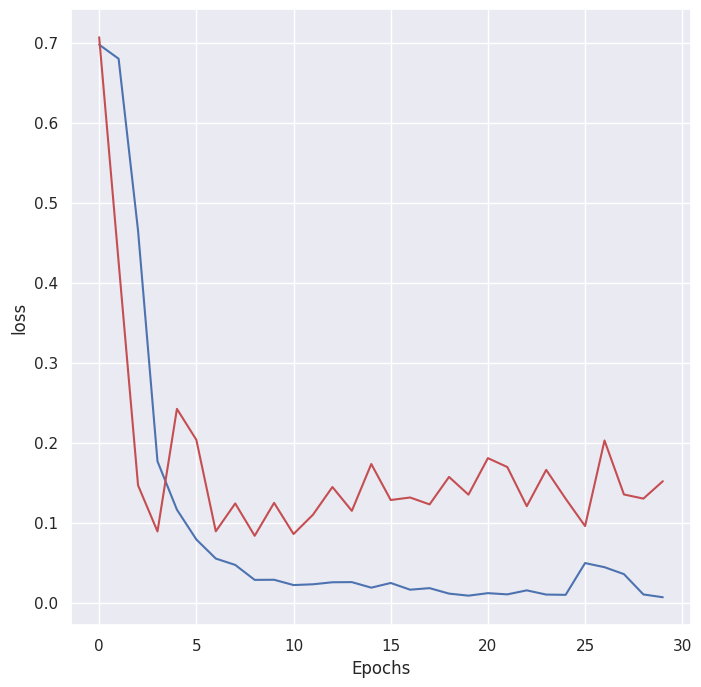

In [461]:
# Visualization of the training process on the loss function
plt.plot(gru_history.history["loss"], color="b")
plt.plot(gru_history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

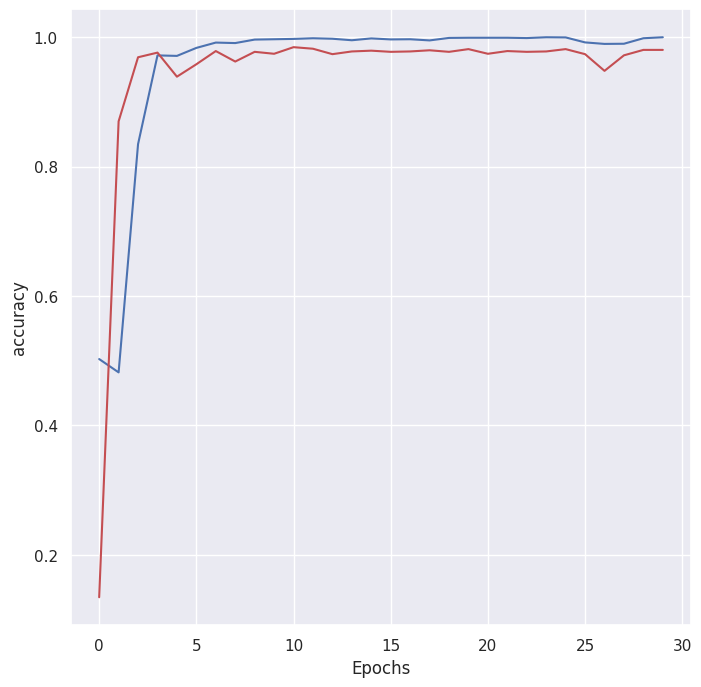

In [462]:
# Visualization of accuracy training
plt.plot(gru_history.history["binary_accuracy"], color="b")
plt.plot(gru_history.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

53/53 [==============================] - 3s 33ms/step


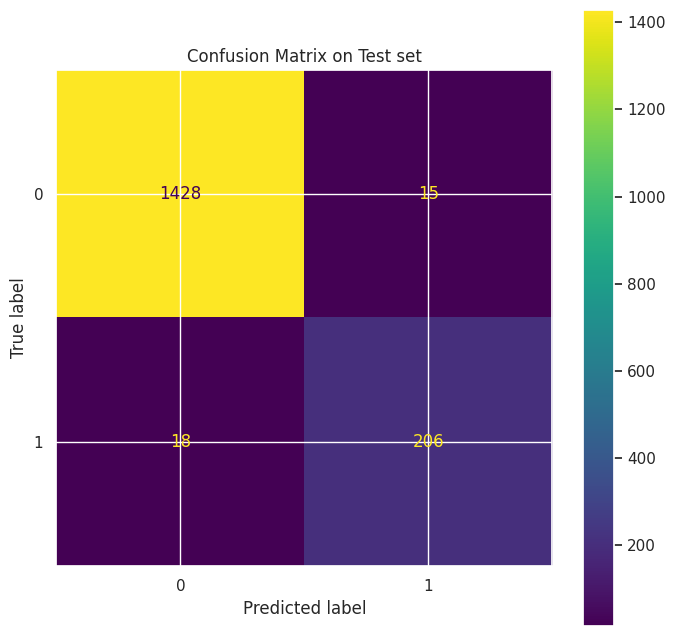

In [463]:
val_prediction = np.round(model_gru.predict(X_val))
# Confusion Matrix
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_predictions(y_val, val_prediction, ax=ax)
plt.show()

In [464]:
train_gru_results = model_gru.evaluate(X_train, np.asarray(y_train), verbose=2, batch_size=256)
valid_gru_results = model_gru.evaluate(X_val, np.asarray(y_val), verbose=2, batch_size=256)
print(f'Train accuracy: {train_gru_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_gru_results[1]*100:0.2f}')

16/16 - 1s - loss: 0.0018 - binary_accuracy: 0.9997 - 1s/epoch - 89ms/step
7/7 - 1s - loss: 0.1516 - binary_accuracy: 0.9802 - 632ms/epoch - 90ms/step
Train accuracy: 99.97
Valid accuracy: 98.02


In [520]:
model_gru.save("models/model_gru.h5")

This GRU model have a quasi perfect binary accuracy with 99.97% on the training set and a really good binary accuracy with 98% on the validation set. However, the binary accuracy doesn't progress any more for both train and validation sets after 7-8 epochs. And we can even clearly see that it overfits starting at epochs 6-7 ! Across the loss curves, validation loss increases slowly but surely from 8% to 15-16%, while train loss is still decreasing to reach less than 1%.\
This fast learning is surely due to Adam optimizer learning rate that we push to 0.01, when it is originally at 0.001, so the model learn 10 times faster, but it starts to learn by heart this dataset and may not be as performant as now with other data.\
With the confusion matrix, we can see that this dense model failed only 15 times to identify a spam (out of 224) and fail 18 times by identifying a ham as spam (out of 1443 instances). It is still really good results, but how this GRU model will react facing new inputs ?

## Modeling LSTM

In [550]:
model_lstm = tf.keras.Sequential([
                  # Word Embedding layer
                  Embedding(vocab_size+1, 64, input_shape=[mail.shape[1],],name="embedding"),

                  # GRU layer to add recurence
                  LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  LSTM(units=32, return_sequences=False), # returns the last output

                  # Couche Dropout pour éviter l'overfitting
                  Dropout(0.4),

                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # Couche Dropout pour éviter l'overfitting
                  Dropout(0.2),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  Dense(1, activation="sigmoid")
])

In [551]:
optimizer= tf.keras.optimizers.Adam(learning_rate = 0.01)
model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [552]:
model_lstm.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 64)            64064     
                                                                 
 lstm_56 (LSTM)              (None, 74, 64)            33024     
                                                                 
 lstm_57 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_49 (Dropout)        (None, 32)                0         
                                                                 
 dense_121 (Dense)           (None, 16)                528       
                                                                 
 dense_122 (Dense)           (None, 8)                 136       
                                                                 
 dropout_50 (Dropout)        (None, 8)               

In [553]:
lstm_history = model_lstm.fit(train_batch,
            epochs=30,
            validation_data=val_batch,
            class_weight=weights)

Epoch 1/30
61/61 [==============================] - 14s 158ms/step - loss: 0.6962 - binary_accuracy: 0.5045 - val_loss: 0.6739 - val_binary_accuracy: 0.8656
Epoch 2/30
61/61 [==============================] - 10s 161ms/step - loss: 0.6943 - binary_accuracy: 0.7247 - val_loss: 0.7145 - val_binary_accuracy: 0.1344
Epoch 3/30
61/61 [==============================] - 10s 157ms/step - loss: 0.6942 - binary_accuracy: 0.4559 - val_loss: 0.6873 - val_binary_accuracy: 0.8656
Epoch 4/30
61/61 [==============================] - 8s 127ms/step - loss: 0.6937 - binary_accuracy: 0.6259 - val_loss: 0.6862 - val_binary_accuracy: 0.8656
Epoch 5/30
61/61 [==============================] - 8s 128ms/step - loss: 0.6936 - binary_accuracy: 0.4587 - val_loss: 0.6908 - val_binary_accuracy: 0.8656
Epoch 6/30
61/61 [==============================] - 9s 142ms/step - loss: 0.6938 - binary_accuracy: 0.7034 - val_loss: 0.6897 - val_binary_accuracy: 0.8656
Epoch 7/30
61/61 [==============================] - 9s 142ms/

#### Evaluation

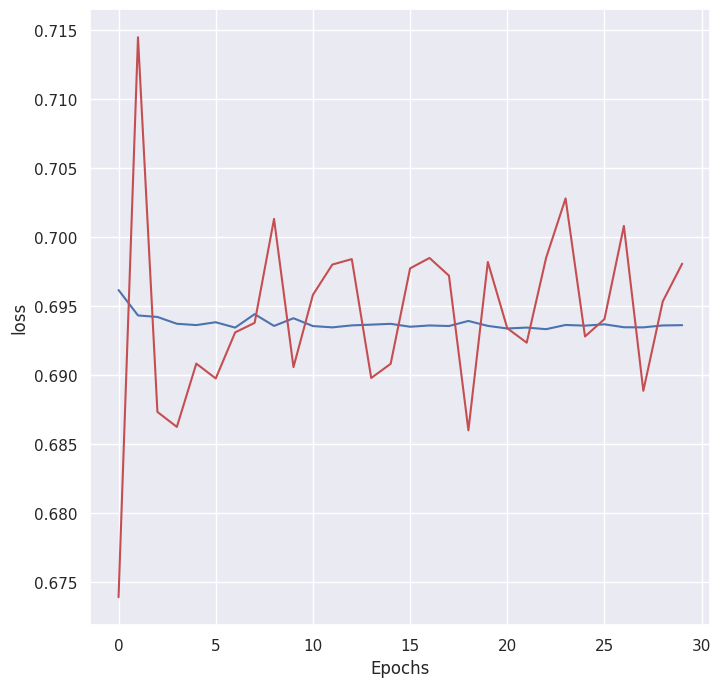

In [554]:
# Visualization of the training process on the loss function
plt.plot(lstm_history.history["loss"], color="b")
plt.plot(lstm_history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

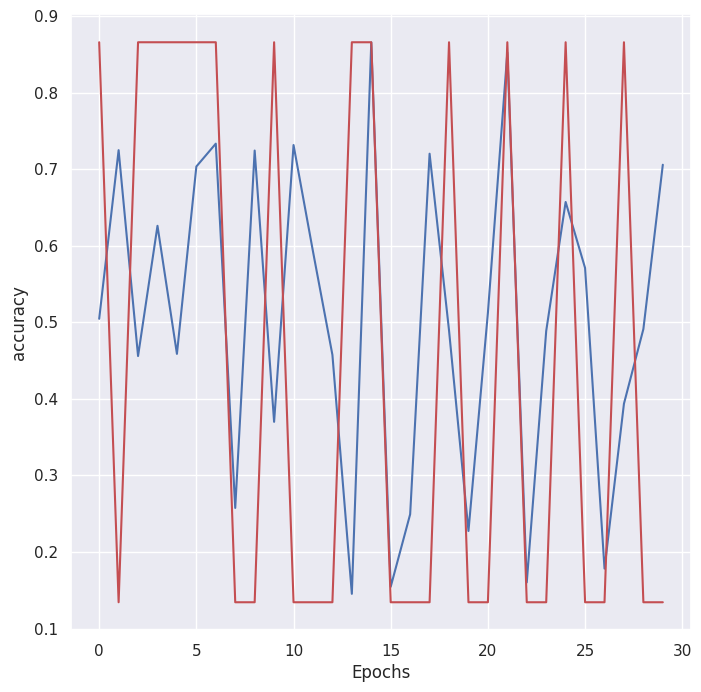

In [555]:
# Visualization of accuracy training
plt.plot(lstm_history.history["binary_accuracy"], color="b")
plt.plot(lstm_history.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

53/53 [==============================] - 3s 38ms/step


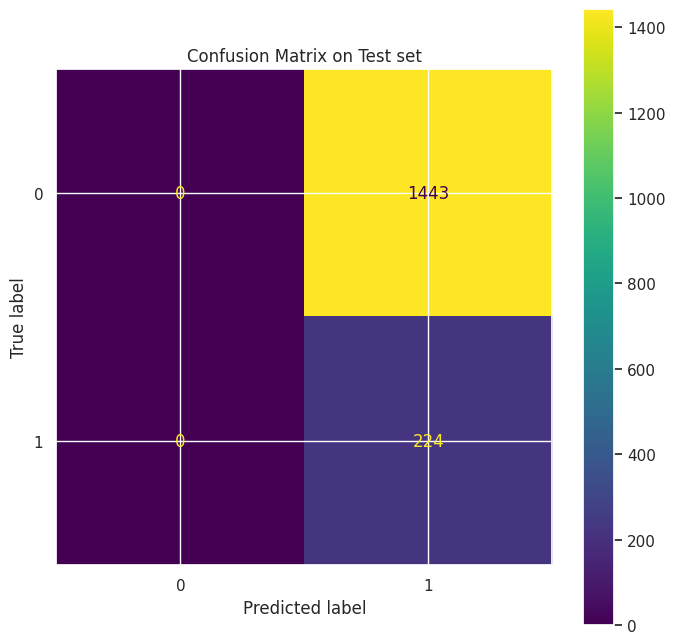

In [556]:
val_prediction = np.round(model_lstm.predict(X_val))
# Confusion Matrix
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_predictions(y_val, val_prediction, ax=ax)
plt.show()

In [557]:
train_lstm_results = model_lstm.evaluate(X_train, np.asarray(y_train), verbose=2, batch_size=256)
valid_lstm_results = model_lstm.evaluate(X_val, np.asarray(y_val), verbose=2, batch_size=256)
print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_lstm_results[1]*100:0.2f}')

16/16 - 2s - loss: 0.6981 - binary_accuracy: 0.1346 - 2s/epoch - 108ms/step
7/7 - 1s - loss: 0.6981 - binary_accuracy: 0.1344 - 1s/epoch - 156ms/step
Train accuracy: 13.46
Valid accuracy: 13.44


In [558]:
model_lstm.save("models/model_lstm.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



This LSTM model has really poor performance ! It doesn't seem to learn effectivelly. As we can see on the loss curves of both training and validation sets, the losses don't change at all and remains at 69%, what means it doesn't learn at all. The validation binary accuracy switch at each epoch from 13.5 to 86.5% and vice versa, what is the percentage distribution between ham and spam.\
With the confusion matrix, we can see that this LSTM model predicted all inputs as spam ! And the switch in validation binary accuracy let us know that at epochs with 86.5% binary accuracy, it predicted all inputs as ham.

## Models performance

In [559]:
# Dense model
print(f'Valid accuracy dense model : {valid_dense_results[1]*100:0.2f}')
print(f'Valid loss dense model : {valid_dense_results[0]*100:0.2f}')

Valid accuracy dense model : 98.32
Valid loss dense model : 5.54


In [560]:
# RNN model
print(f'Valid accuracy RNN model : {valid_srnn_results[1]*100:0.2f}')
print(f'Valid loss RNN model : {valid_srnn_results[0]*100:0.2f}')

Valid accuracy RNN model : 94.78
Valid loss RNN model : 20.24


In [561]:
# GRU model
print(f'Valid accuracy GRU model : {valid_gru_results[1]*100:0.2f}')
print(f'Valid loss GRU model : {valid_gru_results[0]*100:0.2f}')

Valid accuracy GRU model : 98.02
Valid loss GRU model : 15.16


In [562]:
# LSTM model
print(f'Valid accuracy LSTM model : {valid_lstm_results[1]*100:0.2f}')
print(f'Valid loss LSTM model : {valid_lstm_results[0]*100:0.2f}')

Valid accuracy LSTM model : 13.44
Valid loss LSTM model : 69.81


The best model according to accuracy is the Dense model.

In [564]:
model = model_dense

#### Prediction & Confusion Matrix

In [565]:
val_prediction = np.round(model.predict(X_val))
print(classification_report(y_val, val_prediction))

53/53 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1443
           1       0.94      0.93      0.94       224

    accuracy                           0.98      1667
   macro avg       0.97      0.96      0.96      1667
weighted avg       0.98      0.98      0.98      1667



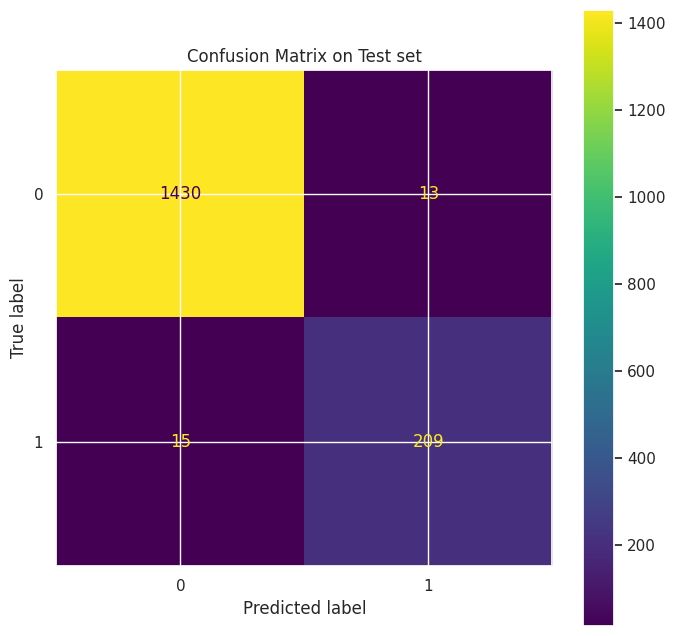

In [566]:
# Confusion Matrix
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_predictions(y_val, val_prediction, ax=ax)
plt.show()

In [567]:
predict_msg = ["Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe.",
               "Call me back please. I tried to contact you 10 times",
               "Congrats on your new iPhone! Click here to claim your prize.",
               "Are you coming to the meeting tomorrow ?",
               "You have won a million dollars! Fill out your bank details here.",
               "Max, can you call me back ? I need your answer to book the train",
               "Hello, can you help me please ? Where should I find the invoice they are asking for ? Do you know how can I find it ?",
               "I had a really good time with you today.",
               "Looking forward to seeing you again.",
               "How are you today my friend ?",
               "See you tomorrow",
               "Are you avalaible next week to go to the sea ?",
               "Say hello to your wife",
               "No, I don't think it's important for her",
               "Go to see John, he's looking for you"]


new_seq = tokenizer.texts_to_sequences(predict_msg)
padded = tf.keras.preprocessing.sequence.pad_sequences(new_seq, padding="post")
predict_spam = model.predict(padded)

for i in range(len(predict_msg)):
  print(predict_msg[i])
  print(predict_spam[i])
  print('\n')

1/1 [==============================] - 0s 22ms/step
Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe.
[0.9999998]


Call me back please. I tried to contact you 10 times
[0.99996364]


Congrats on your new iPhone! Click here to claim your prize.
[1.]


Are you coming to the meeting tomorrow ?
[0.00078385]


You have won a million dollars! Fill out your bank details here.
[0.9956238]


Max, can you call me back ? I need your answer to book the train
[0.9637664]


Hello, can you help me please ? Where should I find the invoice they are asking for ? Do you know how can I find it ?
[1.]


I had a really good time with you today.
[0.9892281]


Looking forward to seeing you again.
[0.98129827]


How are you today my friend ?
[0.24693616]


See you tomorrow
[0.00564524]


Are you avalaible next week to go to the sea ?
[0.9873153]


Say hello to your wife
[0.01153466]


No, I don't think it's important for her
[0.99222606]


Go to see 

#### Saving best model

In [568]:
model.save("models/best_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



## Conclusion

Considering the performances and potential for overfitting, the Dense model seems to be the best choice. It presents high accuracy on both training and validation sets while demonstrating resilience against overfitting.